# Analysis of PGPE and NPGPE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.close('all')

delta = 0.2

def read_data(path):
    df = pd.read_csv(path + 'progress.csv')
    iterations = len(df)
    batch_size = df['BatchSize']
    sigma_1 = []
    sigma_2 = []
    for i in range(iterations):
        policy_params = np.load(path + 'weights_' + str(i) + '.npy')
        #iws = np.load(path + 'iws_' + str(i) + '.npy')
        sigma_1.append(np.exp(policy_params[-2]))
        sigma_2.append(np.exp(policy_params[-1]))
    df['Sigma1'] = sigma_1
    df['Sigma2'] = sigma_2
    df['CumAvgRew'] = np.cumsum(df['AvgRet'])/iterations
    return df

def plot_data(dfs, columns, bottom=-np.infty, top=np.infty, rng=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if type(dfs) is not list:
        dfs = [dfs]
    n_subplots = len(dfs)
    for i in range(n_subplots): 
        df = dfs[i]
        if rng is not None:
            df = df[rng]
        ax.set_xlabel('Iteration')
        x = range(len(df))
        for col in columns:
            y = np.clip(df[col], bottom, top)
            ax.plot(x, y, label=col)
        ax.legend()
    return fig

def plot_ci(mean, std, conf, n_runs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mean.index, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    return fig

# PGPE on Cartpole

## Setting:
* Policy: determinisitc linear w/o bias
* Available random seeds: 107, 583, 850, 730, 808
* Batch size: 100
* Task variant: gym
* Horizon: 200

### Performance (undiscounted) on 5 different random seeds

**Available data**

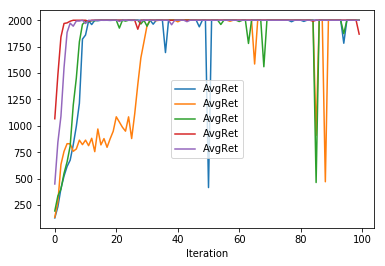

In [2]:
common_path = '../results/pgpe/cartpole/seed_'
seeds = [107, 583, 850, 730, 808]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['AvgRet'])

In [3]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 100


In [4]:
print('Columns:', list(dfs[0]))

Columns: ['StepSize', 'J', 'Grad2Norm', 'GradInftyNorm', 'VarJ', 'AvgRet', 'BatchSize', 'AvgEpLen', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [5]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


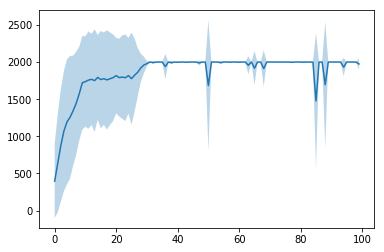

In [6]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['AvgRet']
std = std_df['AvgRet']
plot_ci(mean, std, conf, n_runs)

In [7]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: 1859.337298, c.i. (1693.1591850497898, 2025.5154112677214)


# NPGPE on Cartpole

## Setting:
* Policy: determinisitc linear w/o bias
* Available random seeds: 107, 583, 850, 730, 808
* Batch size: 100
* Task variant: gym
* Horizon: 200

### Performance (undiscounted) on 5 different random seeds

**Available data**

/home/matteo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


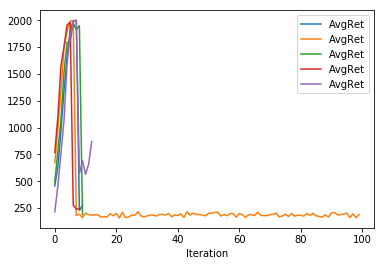

In [16]:
common_path = '../results/npgpe/nobias/cartpole/seed_'
seeds = [107, 583, 850, 730, 808]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['AvgRet'])

In [10]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 100


In [11]:
print('Columns:', list(dfs[0]))

Columns: ['VarJ', 'StepSize', 'BatchSize', 'J', 'AvgRet', 'NatGrad2Norm', 'AvgEpLen', 'NatGradInftyNorm', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [12]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


/home/matteo/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


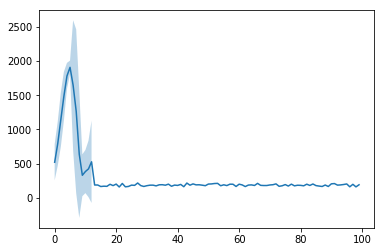

In [13]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['AvgRet']
std = std_df['AvgRet']
plot_ci(mean, std, conf, n_runs)

In [14]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: 279.312266, c.i. (nan, nan)


# NPGPE on Cartpole: the bias problem

## Setting:
* Policy: determinisitc linear + bias
* Available random seeds: 107, 583, 850, 730, 808
* Batch size: 100
* Task variant: gym
* Horizon: 200

### Performance (undiscounted) on 5 different random seeds

**Available data**

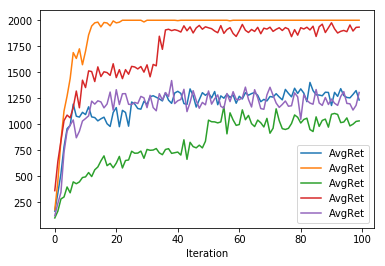

In [15]:
common_path = '../results/npgpe/cartpole_bias/seed_'
seeds = [107, 583, 850, 730, 808]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['AvgRet'])

In [16]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 100


In [17]:
print('Columns:', list(dfs[0]))

Columns: ['AvgEpLen', 'VarJ', 'StepSize', 'NatGradInftyNorm', 'J', 'NatGrad2Norm', 'BatchSize', 'AvgRet', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [18]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


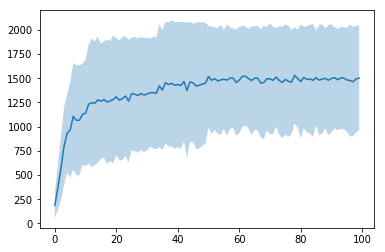

In [24]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['AvgRet']
std = std_df['AvgRet']
plot_ci(mean, std, conf, n_runs)

In [20]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: 1365.223839, c.i. (816.3054894961502, 1914.1421882012132)
